Dataset shape: (20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None

Linear Regression
RMSE : $70,059
R²   : 0.6254

Ridge (CV)
RMSE : $70,067
R²   : 0.6254

Lasso (CV)
RMSE : $70,059
R²   : 0.6254

Model Comparison:
            Model  RMSE ($)     R²
Linear Regression  70059.19 0.6254


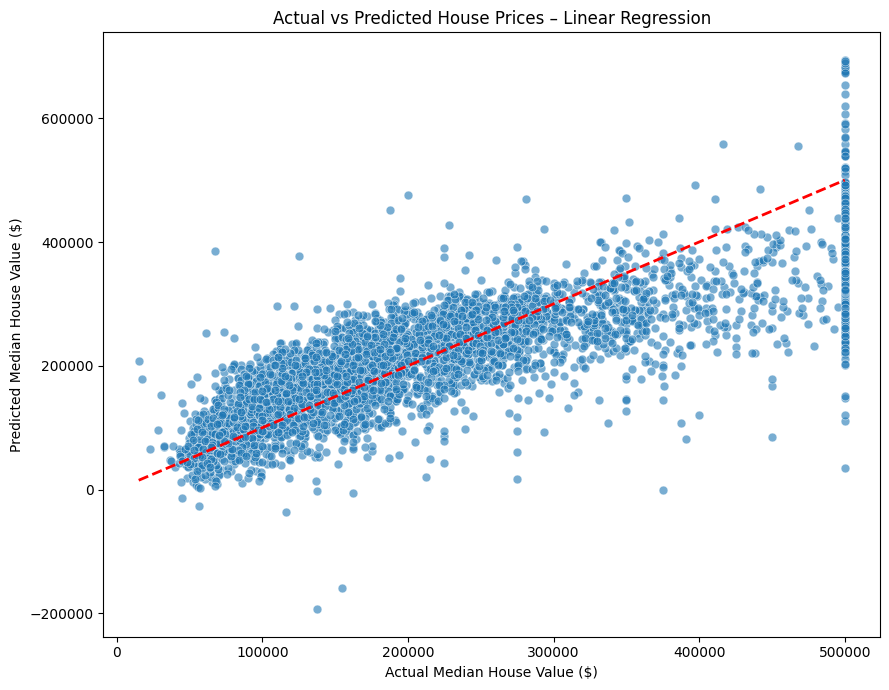

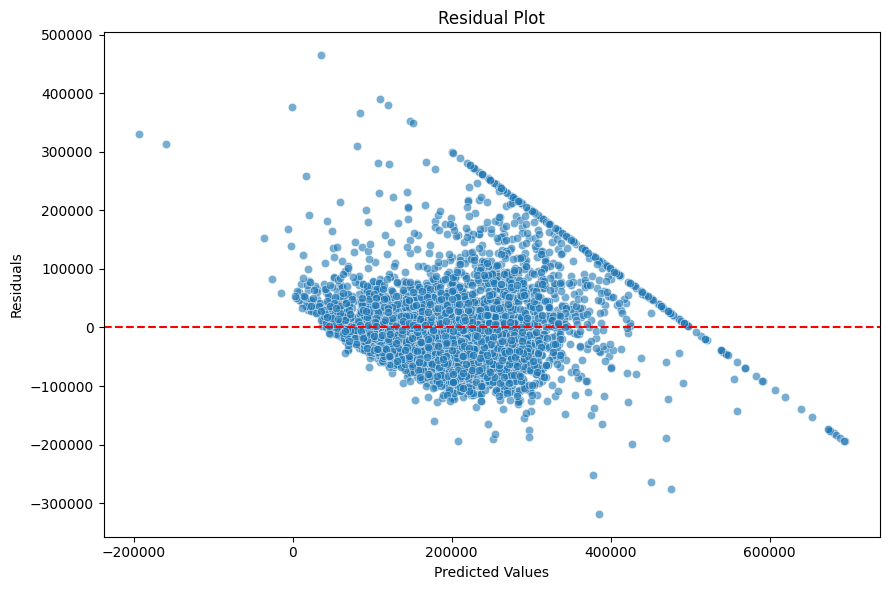

In [1]:
# ────────────────────────────────────────────────────────────────
# California Housing Price Prediction – Multiple Regression + Regularization
# ────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load and inspect
df = pd.read_csv('housing.csv')

print("Dataset shape:", df.shape)
print(df.info())

# 2. Preprocessing pipeline
num_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']
cat_features = ['ocean_proximity']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# 3. Features and target
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (CV)': RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5),
    'Lasso (CV)': LassoCV(alphas=np.logspace(-3, 3, 50), cv=5, max_iter=2000)
}

results = []

for name, model in models.items():
    # Create full pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Train
    pipe.fit(X_train, y_train)

    # Predict
    y_pred = pipe.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'RMSE ($)': round(rmse, 2),
        'R²': round(r2, 4)
    })

    print(f"\n{name}")
    print(f"RMSE : ${rmse:,.0f}")
    print(f"R²   : {r2:.4f}")

# 6. Summary table
print("\nModel Comparison:")
print(pd.DataFrame(results).to_string(index=False))

# 7. Visual: Actual vs Predicted (best model - usually Ridge or Linear)
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
]).fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(9, 7))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6, s=40)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Median House Value ($)")
plt.ylabel("Predicted Median House Value ($)")
plt.title("Actual vs Predicted House Prices – Linear Regression")
plt.tight_layout()
plt.show()

# 8. Residual plot
residuals = y_test - y_pred_best
plt.figure(figsize=(9, 6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

In [2]:
ridge_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', RidgeCV(alphas=np.logspace(-3, 6, 60), cv=5))
])
ridge_pipe.fit(X_train, y_train)
y_pred_ridge = ridge_pipe.predict(X_test)

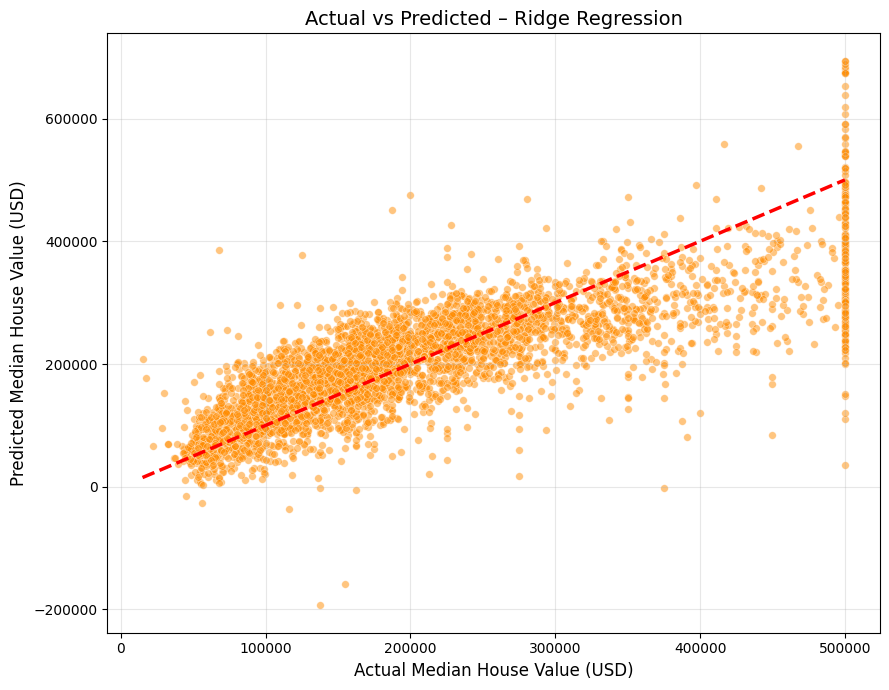

In [3]:
plt.figure(figsize=(9, 7))
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.5, s=30, color='darkorange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2.5)
plt.xlabel("Actual Median House Value (USD)", fontsize=12)
plt.ylabel("Predicted Median House Value (USD)", fontsize=12)
plt.title("Actual vs Predicted – Ridge Regression", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

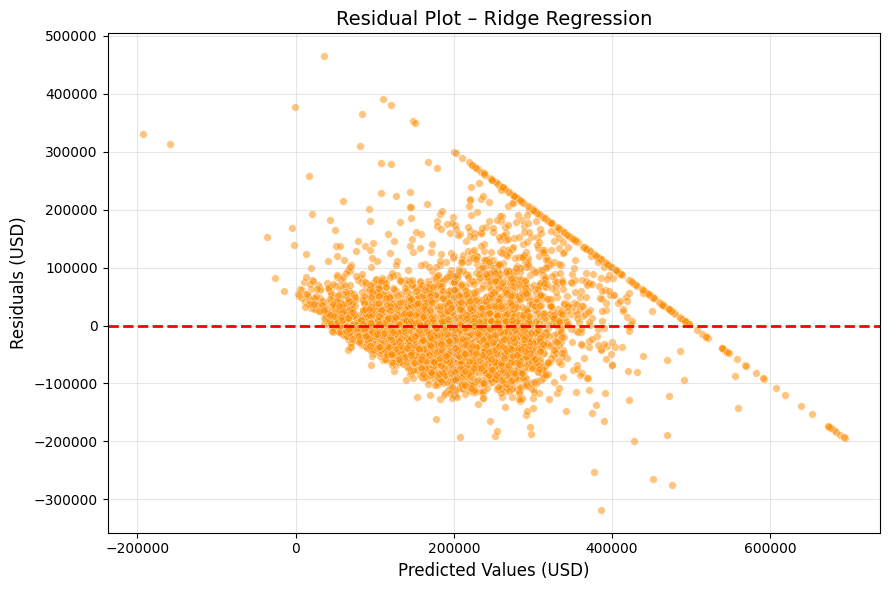

In [4]:
residuals_ridge = y_test - y_pred_ridge
plt.figure(figsize=(9, 6))
sns.scatterplot(x=y_pred_ridge, y=residuals_ridge, alpha=0.5, s=30, color='darkorange')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Values (USD)", fontsize=12)
plt.ylabel("Residuals (USD)", fontsize=12)
plt.title("Residual Plot – Ridge Regression", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

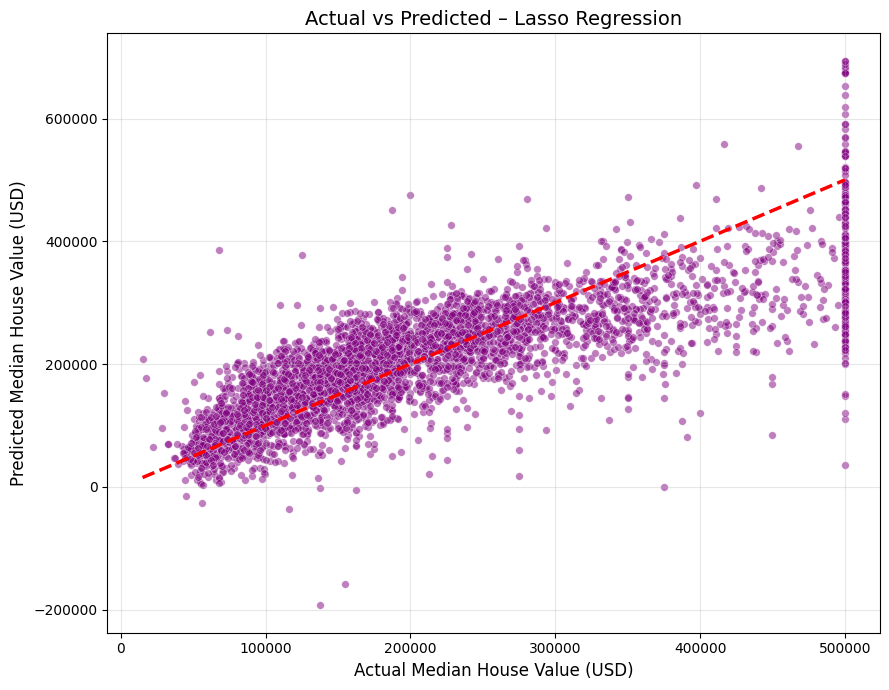

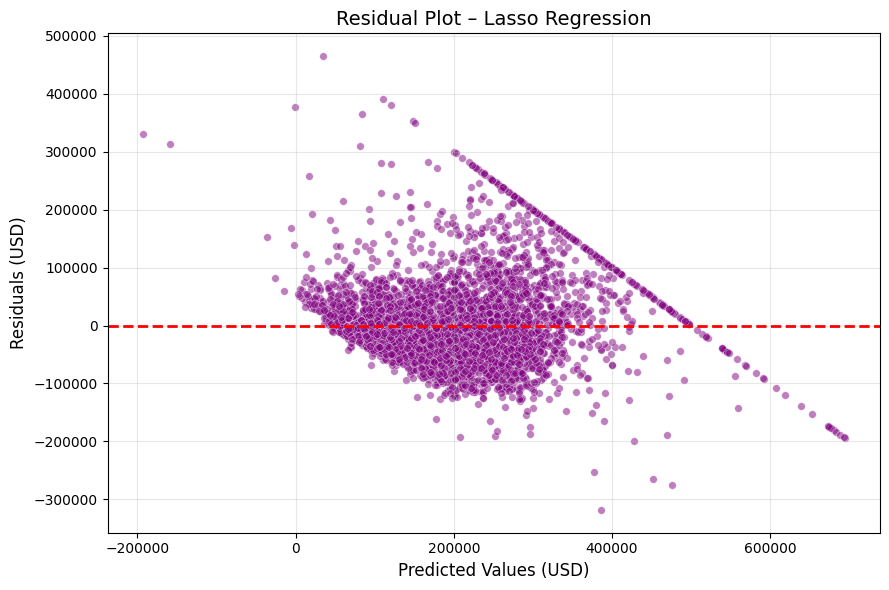

In [5]:
lasso_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', LassoCV(alphas=np.logspace(-3, 6, 60), cv=5, max_iter=3000))
])
lasso_pipe.fit(X_train, y_train)
y_pred_lasso = lasso_pipe.predict(X_test)

# Plot 3A: Actual vs Predicted - Lasso
plt.figure(figsize=(9, 7))
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.5, s=30, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2.5)
plt.xlabel("Actual Median House Value (USD)", fontsize=12)
plt.ylabel("Predicted Median House Value (USD)", fontsize=12)
plt.title("Actual vs Predicted – Lasso Regression", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3B: Residual Plot - Lasso
residuals_lasso = y_test - y_pred_lasso
plt.figure(figsize=(9, 6))
sns.scatterplot(x=y_pred_lasso, y=residuals_lasso, alpha=0.5, s=30, color='purple')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Values (USD)", fontsize=12)
plt.ylabel("Residuals (USD)", fontsize=12)
plt.title("Residual Plot – Lasso Regression", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()